# Assignment 3: Tunably Rugged Landscapes
In our assignment last week we got our first hillclimber up and running, while in class week started to talk about fitness landscapes to begin thinking about search spaces, and population-based evolutionary algorithms to start complexifying how we traverse these search spaces.  In this week's assignment, we'll start to put these two things together and begin toying around with the pandora's box of algorithmic experimentation.

In particular, we'll explore the idea of generating parameterized fitness functions to being to explore the relationship between the type of problem we're trying to solve, and what features our evolutionary algorithm should have to solve it.  

*Note*: I know this looks like a lot of coding!  While we are building valuable infastructure here, much of the solutions here are modifications on prior work (from eariler in this assignment or the last one), and can largely be copy-and-pasted here, or written once as a function to call again later.  Despite this, it's still always a good idea to start in on assignments early (even if just reading through all the questions to estimate how long it might take you to complete)

In [1]:
# imports
import numpy as np
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)

import scipy.stats # for finding statistical significance
import random
import pandas as pd

### N-K Landscape
In general, you'll be more likely to have a problem provided to you, rather than have to design a fitness funciton by hand.  So in this week's assignment, I'll provide the full fitness-landscape-generating function for you.  The below function implements Kaffman's N-K Landscape.  While it's not entirely necessary for you to understand every implementaton detail below, the N-K landscape idea is chosen because it's a particularly interesting toy problem -- and more reading on it can be found via many online resources (e.g. Kauffman and Weinberger's *The NK model of rugged fitness landscapes and its application to maturation of the immune response* -- inlcuded in the assigment zip folder as it is firewalled online)

The main things to know about the NK model are that:  It is a model of a tunably rugged fitness landscape, that means we have parameters that can affect the shape and ruggedness of the fitness landscape produced by this model.  While there are many variations, here we follow the original (simplest) model that includes just two parameters: **N** defines the length of the binary bit string genome, while **K** defines the ruggedness of the landscape (in particular how the fitness of each allele depends on other loci (nearby genes) in the genotype.  

*Note*: This is fully implemented and no action is needed from you, besides running the code block.

In [2]:
class Landscape:
    """ N-K Fitness Landscape
    """

    
    def __init__(self, n=10, k=2):
        self.n = n # genome length
        self.k = k # number of other loci interacting with each gene
        self.gene_contribution_weight_matrix = np.random.rand(n,2**(k+1)) # for each gene, a lookup table for its fitness contribution, which depends on this gene's setting and also the setting of its interacting neighboring loci
        
    # find values of interacting loci
    def get_contributing_gene_values(self, genome, gene_num):     
        contributing_gene_values = ""
        for i in range(self.k+1): # for each interacing loci (including the location of this gene itself)
            contributing_gene_values += str(genome[(gene_num+i)%self.n]) # for simplicity we'll define the interacting genes as the ones immediately following the gene in question.  Get the values at each of these loci
        return contributing_gene_values # return the string containing the values of all loci which affect the fitness of this gene
    
    # find the value of a partiuclar genome
    def get_fitness(self, genome):
        gene_values = np.zeros(self.n) # the value of each gene in the genome
        for gene_num in range(len(genome)): # for each gene
            contributing_gene_values = self.get_contributing_gene_values(genome, gene_num) # get the values of the loci which affect it
            gene_values[gene_num] = self.gene_contribution_weight_matrix[gene_num,int(contributing_gene_values,2)] # use the values of the interacting loci (converted from a binary string to base-10 index) to find the lookup table entry for this combination of genome settings
        return np.mean(gene_values) # define the fitness of the full genome as the average of the contribution of its genes (and return it for use in the evolutionary algoirthm)

### Hillclimber
Based on the hillclimber function from you last assignment (and informed by the posted solution, if you wish), copy an slightly modify the hillclimber to use this fitnes function.  For sake of running multiple trials, also please modify the record keeping to reutrn the solutions after the completion of the algorithm rather than printing them out during evolution. 

*Hint:* In python, functions can be treated as objects (e.g. passed as an argument to another function)

In [3]:
def hillclimber(total_generations = 100, bit_string_length = 10, num_elements_to_mutate= 1, fitness_function=None):
    """ Basic hillclimber, copied from last assignment
        
        parameters: 
        total_generations: (int) number of total iterations for stopping condition
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
                           
        returns:
        solution: (numpy array) best solution found
        solution_fitness: (float) fitness of returned solution
        solution_generation: (int) generaton at which most fit solution was first discovered
    """
    
    # the initialization proceedure
    parent = []
    for i in range(bit_string_length):
        parent.append(random.randint(0,1))
    fitness_parent = fitness_function(parent)

        
    # initialize record keeping
    solution = np.zeros(bit_string_length)
    solution_fitness = 0
    solution_generation = 0
    
    for i in range(total_generations): # repeat
        
        # the modification procedure
        child = parent.copy()
        mutate_elements = []
        for j in range(num_elements_to_mutate):
            mutate_elements.append(random.randint(0,bit_string_length-1))
        for j in range(len(mutate_elements)):
            bit = child[mutate_elements[j]]
            if bit==1:
                child[mutate_elements[j]] = 0
            else:
                child[mutate_elements[j]] = 1
        
        # the assessement procedure
        fitness_child = fitness_function(child)
        if fitness_child > fitness_parent:
            
            # selection procedure
            parent = child
            fitness_parent = fitness_child
        
            # record keeping
            solution = np.array(parent).astype(np.float)
            solution_fitness = fitness_parent
            solution_generation = i
            
    return solution, solution_fitness, solution_generation

### Q1: Landscape Ruggedness's effect on Hillclimbing
In class we discussed the potential for the fitness landscape to greatly affect a given search algorithm.  Let't start by generating varyingly rugged landscapes, and investigating how this impacts the effectiveness of a standard hillclimber.  

For each value of `k = 0..14` and a genome legnth of `15` please generate 100 unique fitness landscapes, and record the fitness value and time to convergence (when the most fit solution was found) for the hillclimber algorithm above on that landscape.  Print out the mean results for each `k` as you go to keep track of progress.  This output may look something like this:

<img src="terminal_output.png" align="left"/>

In [4]:
# hyperparameters
n=15; max_k=15; repetitions = 100

# initialize array to record results over different settings of k and repeated trials
solutions_found = np.zeros((max_k,repetitions,n))
fitness_found = np.zeros((max_k,repetitions))
generation_found = np.zeros((max_k,repetitions))

# initilize output
print(' k  mean fitness  mean generation found')
print('--  ------------  ---------------------')

# for many values of k
for k in range (max_k):
    # for many repeated (independent -- make sure your results differ each run!) trials
    for j in range (repetitions):
        l = Landscape(n, k) # generate a random fitness landscape with this level of ruggeddness
 
        # run a hillclimber and record outputs
        solutions_found[k][j], fitness_found[k][j], generation_found[k][j] = hillclimber(bit_string_length=n, fitness_function=l.get_fitness)

        
        
    # print average results for all repitions of this k
#     print(k)
#     print(np.mean(fitness_found[k]))
#     print(np.mean)
    print('{}\t{}\t\t{}'.format(k, np.round(np.mean(fitness_found[k]), 3), np.round(np.mean(generation_found[k]), 3)))
    

 k  mean fitness  mean generation found
--  ------------  ---------------------
0	0.659		39.77
1	0.697		40.57
2	0.703		36.67
3	0.701		34.88
4	0.699		31.41
5	0.686		30.88
6	0.697		27.51
7	0.692		27.33
8	0.666		24.47
9	0.666		19.21
10	0.658		23.48
11	0.645		17.48
12	0.623		19.02
13	0.61		15.74
14	0.6		15.7


Let's also record this result in a nested dictionary to be able to recall it later (for comparison to other results).  There is an implementation given below, but you're welcome to use `pandas` if you're more comforatable with that library for data manipulation and visualization.

In [5]:
experiment_results = {}
experiment_results["hillclimber"] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found}

### Q2: Plotting Results
Please visualize the above terminal output in a figure (feel free to recycle code from previous assignments).  You'll be generating this same plot many time (and even comparing multiple runs on a single figure), so you may want to invest in implementing this as a function at some point during this assigment -- but that is not strictly necessary now, and fell free to ignore the code stub below.  

In particular, please plot the `Time to Convergence (Generations)` and `Fitness` values (as you vary `K`) as two separate figures, as a single figure with multiple y-axes is messy and confusing.  Please include 95% boostrapped confidence intervals over your 100 repitions for eack `K`.  Please also inlcude the title of each experiment as a legend (for now just `hillclimber` is sufficient for this baseline case, and titles will make more sense in follow up experimental conditions).

[array([0.64712366, 0.66957644]), array([0.68550348, 0.7071013 ]), array([0.69288909, 0.71237307]), array([0.69114486, 0.71128359]), array([0.6908174 , 0.70798604]), array([0.65848358, 0.69622547]), array([0.68844425, 0.70616464]), array([0.68427795, 0.7002047 ]), array([0.63432824, 0.68085733]), array([0.63559576, 0.68073574]), array([0.6331735 , 0.66851856]), array([0.61065792, 0.66232258]), array([0.58387324, 0.64489887]), array([0.57011367, 0.63505752]), array([0.55712137, 0.62635412])]
[array([36.55, 43.18]), array([37.16, 44.35]), array([32.68, 41.17]), array([30.61, 39.95]), array([27.75, 35.63]), array([26.7 , 35.51]), array([23.67, 32.09]), array([23.59, 31.54]), array([20.89, 28.78]), array([15.88, 23.34]), array([19.39, 28.27]), array([14.52, 21.52]), array([15.46, 23.54]), array([12.88, 19.39]), array([12.36, 20.06])]


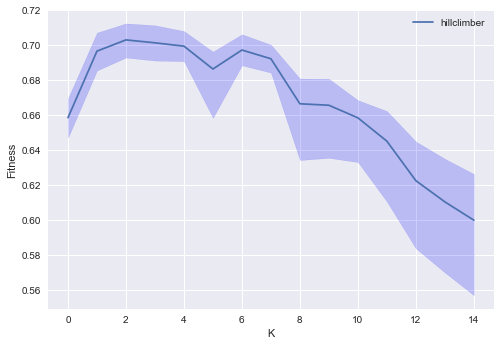

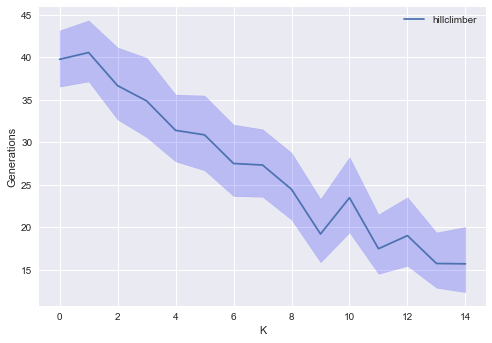

In [6]:
def plot_mean_and_bootstrapped_ci(input_data = None, title=None, name = "change me", x_label = "K", y_label="change me", y_limit = None):
    """
    
    parameters: 
    input_data: (numpy array of shape (max_k, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """

    max_k = input_data.shape[0]

#     plt.title(name)
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     plt.legend()
#     plt.show()

    CIs = []
    mean_values = []
    for i in range(max_k):
        mean_values.append(np.mean(input_data[i]))
        CIs.append(bootstrap.ci(input_data[i], statfunction=np.mean))
    mean_values=np.array(mean_values)
    
    print(CIs)
    high = []
    low = []
    for i in range(len(CIs)):
        low.append(CIs[i][0])
        high.append(CIs[i][1])
    
    low = np.array(low)
    high = np.array(high)
    fig, ax = plt.subplots()
    y = range(0, max_k)
    ax.plot(y, mean_values, label=name)
    ax.fill_between(y, high, low, color='b', alpha=.2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    if (title) and len(title>0):
        ax.set_title(name)
    
    
plot_mean_and_bootstrapped_ci(input_data=fitness_found, name='hillclimber', y_label="Fitness")
plot_mean_and_bootstrapped_ci(input_data=generation_found, name='hillclimber', y_label="Generations")

### Q3: Analysis of Hillclimber on Varying Ruggedness 
What do you notice about the trend line?  Is this what you expected?  Why or why not?

**The trend lines for both of these plots look similar. They both initially trend upward, then roughly start to fall (with some bouncing up and down). This definitely isn't what I initially expected from these trend lines. I expected the trend line for fitness to initially start high and drop off as the ruggedness increased since it would be a harder fitness landscape to fit to, but as I think about it more this trend line starts to make sense. While ruggedness may make it much tougher to find the global optima, it could make it easier to find a local optima. As for the generational convergence trend line, I initially expected it would be lower and as the ruggedness of the landscape went up, it would also go up. The trend line begins to make more sense when thinking more deeply about a rugged landscape. It may be hard to get off of the local optima that we find with the step size we have. I am almost definitely missing some considerations here. This is a very interesting topic to think about.**

### Q4: Random Restarts
One of the methods we talked about as a potential approach to escaping local optima in highly rugged fitness landscapes was to randomly restart search.  Using the same number of total generations (`100`), please implement a function which restarts search to a new random initialization every `20` generations (passing this value as an additoinal parameter to your hillclimber function).  Feel free to just copy and paste the hillclimber code block here to modify, for the sake of simplicity and easy gradability.  

In [7]:
def hillclimber(total_generations = 100, bit_string_length = 10, num_elements_to_mutate= 1, fitness_function=None, restart_every = None):
    """ Basic hillclimber, copied from last assignment
        
        parameters: 
        total_generations: (int) number of total iterations for stopping condition
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        restart_every: (int) how frequently to randomly restart the hillclimber
                           
        returns:
        solution: (numpy array) best solution found
        solution_fitness: (float) fitness of returned solution
        solution_generation: (int) generaton at which most fit solution was first discovered
    """

    # the initialization proceedure
    parent = []
    best = []
    for i in range(bit_string_length):
        parent.append(random.randint(0,1))
    fitness_parent = fitness_function(parent)

        
    # initialize record keeping
    solution = np.zeros(bit_string_length)
    solution_fitness = 0
    solution_generation = 0
    
    for i in range(total_generations): # repeat
        
        if (total_generations % restart_every)==0:
            parent=[]
            for j in range(bit_string_length):
                parent.append(random.randint(0,1))
            fitness_parent = fitness_function(parent)
            
        # the modification procedure
        child = parent.copy()
        mutate_elements = []
        for j in range(num_elements_to_mutate):
            mutate_elements.append(random.randint(0,bit_string_length-1))
        for j in range(len(mutate_elements)):
            bit = child[mutate_elements[j]]
            if bit==1:
                child[mutate_elements[j]] = 0
            else:
                child[mutate_elements[j]] = 1
        
        # the assessement procedure
        fitness_child = fitness_function(child)
        if fitness_child > fitness_parent:
            
            # selection procedure
            parent = child.copy()
            fitness_parent = fitness_child
        
        if fitness_parent > fitness_function(best):
            # record keeping
            best = parent.copy()
            solution = np.array(parent).astype(np.float)
            solution_fitness = fitness_parent
            solution_generation = i
                    
    return solution, solution_fitness, solution_generation

### Q4b: Run Experiment
Slightly modify (feel free to copy and paste here) your experiment running code black above to analyze the effect of modifying `K` on `Time to Convergence (Generations)` and `Fitness`, again print progress and plotting results.  Please also save these results (and subsequent new ones) to your `experimental_results` dictionary for later use.

In [8]:
name = 'hillclimber_random_restarts'
# hyperparameters
n=15; max_k=15; repetitions = 100; restart_every=20

# initialize array to record results over different settings of k and repeated trials
solutions_found = np.zeros((max_k,repetitions,n))
fitness_found = np.zeros((max_k,repetitions))
generation_found = np.zeros((max_k,repetitions))

# initilize output
print(' k  mean fitness  mean generation found')
print('--  ------------  ---------------------')

# for many values of k
for k in range (max_k):
    # for many repeated (independent -- make sure your results differ each run!) trials
    for j in range (repetitions):
        l = Landscape(n, k) # generate a random fitness landscape with this level of ruggeddness
 
        # run a hillclimber and record outputs
        solutions_found[k][j], fitness_found[k][j], generation_found[k][j] = hillclimber(bit_string_length=n, restart_every=restart_every, fitness_function=l.get_fitness)

        
        
    # print average results for all repitions of this k
#     print(k)
#     print(np.mean(fitness_found[k]))
#     print(np.mean)
    print('{}\t{}\t\t{}'.format(k, np.round(np.mean(fitness_found[k]), 3), np.round(np.mean(generation_found[k]), 3)))
    
experiment_results[name] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found}

 k  mean fitness  mean generation found
--  ------------  ---------------------
0	0.632		50.58
1	0.668		50.71
2	0.683		44.33
3	0.688		51.38
4	0.693		48.52
5	0.696		46.81
6	0.697		48.91
7	0.697		50.33
8	0.698		51.07
9	0.698		51.38
10	0.699		48.06
11	0.7		51.91
12	0.701		49.15
13	0.701		55.32
14	0.701		49.09


[array([0.62162242, 0.64421172]), array([0.6581965 , 0.67689326]), array([0.67543573, 0.69031684]), array([0.68131534, 0.69433178]), array([0.68651645, 0.69916596]), array([0.69065111, 0.70061929]), array([0.69243161, 0.70250994]), array([0.69108863, 0.70232075]), array([0.69247229, 0.70381026]), array([0.69326335, 0.70268836]), array([0.69392391, 0.70462566]), array([0.69342622, 0.70634033]), array([0.69637019, 0.70657602]), array([0.69512634, 0.70660221]), array([0.6957118 , 0.70645015])]
[array([45.09, 55.76]), array([44.96, 56.45]), array([38.72, 50.22]), array([45.7 , 56.85]), array([43.03, 53.85]), array([40.77, 52.37]), array([43.5 , 54.35]), array([44.51, 55.96]), array([45.58, 56.37]), array([45.61, 57.14]), array([41.96, 54.28]), array([45.7 , 58.22]), array([43.74, 54.76]), array([49.91, 60.3 ]), array([43.47, 54.77])]


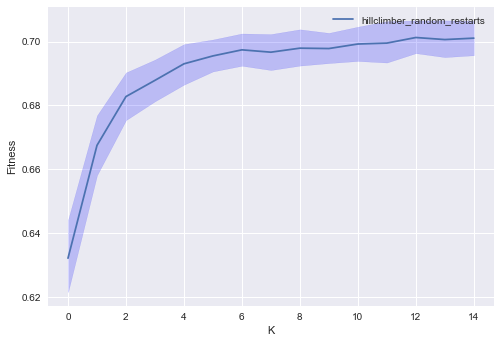

In [9]:
#plotting 
plot_mean_and_bootstrapped_ci(input_data=fitness_found, name=name, y_label="Fitness")
plot_mean_and_bootstrapped_ci(input_data=generation_found, name=name, y_label="Generations")

### Q5: Analysis of Random Restarts
What trends do you see?  Is this what you were expecting?  How does this compare to the original hillclimber algorithm without random resets (please not any y-axis differences when comparing values/shapes of the curves)?

**The trend line for fitness with respect to ruggedness shows a steady increase until it plateaus at around 70%. Early on as ruggedness increases, it appears so does fitness. This suggests that the random restarts help the hill climber find steeper hills (maxima) especially as the landscape becomes more rugged which is potentially increasing the number of these hills. The generational convergence to this fitness shows that the best candidates are being found at roughly the same generation regardless of ruggedness of the landscape. All of the best candidates are found in the 40-60 generational range. This differs largely from hillclimber without these restarts since it does not improve in fitness as ruggedness increases. This is probably due to the hillclimber being stuck on a lower local optima and not being able to find its way out. This would also explain why the generational convergence was so quick for these more rugged landscapes in the hillclimber without restarts.**

### Q6: Modifying mutation size
We've talked about a number of other potential modifications/complexifications to the original hillclimber aglorithm in class, so let's experiment with some of them here.  Here, please modying your above a hillclimber (again please just copy and paste the code block here) to mutate multiple loci when generating the child from a parent.

*Hint*: Be careful of the difference between modifying multiple genes and modifying the same gene multiple times

In [10]:
def hillclimber(total_generations = 100, bit_string_length = 10, num_elements_to_mutate= 1, fitness_function=None, restart_every = None):
    """ Basic hillclimber, copied from last assignment
        
        parameters: 
        total_generations: (int) number of total iterations for stopping condition
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        restart_every: (int) how frequently to randomly restart the hillclimber
                           
        returns:
        solution: (numpy array) best solution found
        solution_fitness: (float) fitness of returned solution
        solution_generation: (int) generaton at which most fit solution was first discovered
    """

    # the initialization proceedure
    parent = []
    best = []
    for i in range(bit_string_length):
        parent.append(random.randint(0,1))
    fitness_parent = fitness_function(parent)

        
    # initialize record keeping
    solution = np.zeros(bit_string_length)
    solution_fitness = 0
    solution_generation = 0
    
    for i in range(total_generations): # repeat
        
        if (total_generations % restart_every)==0:
            parent=[]
            for j in range(bit_string_length):
                parent.append(random.randint(0,1))
            fitness_parent = fitness_function(parent)
            
        # the modification procedure
        child = parent.copy()
        mutate_elements = []
        mutate_elements = random.sample(range(0, bit_string_length-1), num_elements_to_mutate)
        for j in range(len(mutate_elements)):
            bit = child[mutate_elements[j]]
            if bit==1:
                child[mutate_elements[j]] = 0
            else:
                child[mutate_elements[j]] = 1
        
        # the assessement procedure
        fitness_child = fitness_function(child)
        if fitness_child > fitness_parent:
            
            # selection procedure
            parent = child.copy()
            fitness_parent = fitness_child
        
        if fitness_parent > fitness_function(best):
            # record keeping
            best = parent.copy()
            solution = np.array(parent).astype(np.float)
            solution_fitness = fitness_parent
            solution_generation = i
                            
    return solution, solution_fitness, solution_generation

### Q6b: Expectations
In this experiment, let's set the number of elements to be mutated to `5` when generating a new child.

Before running the code, what do (did) you expect the result to be based on the results of the original hillclimber, the random restart condition, and the implications that a larger mutatoin rate may have?

**Depending on whether or not we are running this with or without restarts, my expectations may differ some. I'm going to run it without restarts to exemplify the difference it makes on the original hillclimber. In this situation, I expect that a larger mutation will allow for more exploration, but it may also bounce around the fitness landscape making it difficult for it to converge to very high values of fitness without getting lucky. As for the generational time it will take, I suspect that it will be a bit more random without a definite trend since the changes being made each iteration will be larger thus causing this generational convergence to bounce around drastically.**

### Q7: Run experiment
Run the experiment and visualize (similar to **Q4b**, and feel free to copy a paste here again) to analyze the effect of a larger mutation size on the realationship between `K` and `Time to Convergence (Generations)` / `Fitness`.

In [11]:
name = 'hillclimber_larger_mutations'
# hyperparameters
n=15; max_k=15; repetitions = 100; restart_every=100; num_elements_to_mutate=5

# initialize array to record results over different settings of k and repeated trials
solutions_found = np.zeros((max_k,repetitions,n))
fitness_found = np.zeros((max_k,repetitions))
generation_found = np.zeros((max_k,repetitions))

# initilize output
print(' k  mean fitness  mean generation found')
print('--  ------------  ---------------------')

# for many values of k
for k in range (max_k):
    # for many repeated (independent -- make sure your results differ each run!) trials
    for j in range (repetitions):
        l = Landscape(n, k) # generate a random fitness landscape with this level of ruggeddness
 
        # run a hillclimber and record outputs
        solutions_found[k][j], fitness_found[k][j], generation_found[k][j] = hillclimber(bit_string_length=n, restart_every=restart_every, fitness_function=l.get_fitness, num_elements_to_mutate=num_elements_to_mutate)

        
        
    # print average results for all repitions of this k
#     print(k)
#     print(np.mean(fitness_found[k]))
#     print(np.mean)
    print('{}\t{}\t\t{}'.format(k, np.round(np.mean(fitness_found[k]), 3), np.round(np.mean(generation_found[k]), 3)))
experiment_results[name] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found}

 k  mean fitness  mean generation found
--  ------------  ---------------------
0	0.626		49.72
1	0.676		50.45
2	0.676		52.71
3	0.693		48.23
4	0.695		52.2
5	0.694		50.17
6	0.697		48.22
7	0.706		50.53
8	0.704		49.64
9	0.702		44.98
10	0.704		48.0
11	0.696		47.24
12	0.704		53.25
13	0.705		47.74
14	0.701		50.03


[array([0.61512971, 0.63672451]), array([0.66694815, 0.6846246 ]), array([0.66939682, 0.68296712]), array([0.68714236, 0.69965411]), array([0.68901521, 0.70061588]), array([0.68943109, 0.69977206]), array([0.69206174, 0.70240164]), array([0.7003688 , 0.71218118]), array([0.6988217, 0.7099389]), array([0.69663412, 0.7082608 ]), array([0.6988288 , 0.71044576]), array([0.69089742, 0.70254227]), array([0.69854671, 0.71002126]), array([0.69949341, 0.71078659]), array([0.69667925, 0.70641324])]
[array([44.15, 55.13]), array([44.54, 56.17]), array([46.76, 58.54]), array([42.48, 54.  ]), array([46.55, 57.82]), array([44.13, 56.17]), array([42.7 , 53.47]), array([45.08, 55.88]), array([43.73, 55.75]), array([39.81, 50.45]), array([42.01, 54.06]), array([41.4 , 52.94]), array([47.3 , 59.13]), array([42.32, 53.41]), array([44.35, 55.38])]


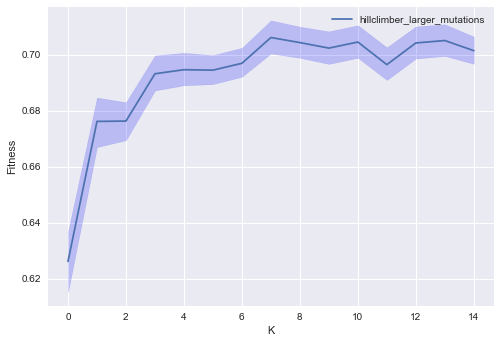

In [12]:
# plotting
plot_mean_and_bootstrapped_ci(input_data=fitness_found, name=name, y_label="Fitness")
plot_mean_and_bootstrapped_ci(input_data=generation_found, name=name, y_label="Generations")

### Q7b: Analysis
Is this what you expected/predicted?  If not, what is different and why might that be?

**This is slightly different than I expected and looks quite similar to the random restart case. The fitness values are relatively high compared to what I might have expected. They are lower on the less rugged landscape which makes sense with my expecations. I believe the reason they tend to be higher in the more rugged landscapes is due to being able to bounce around and land on a hill since it is more likely when there are more hills. The generational convergence is similar to what I predicted with some vaules being higher and some lower, but they do all fall in the range of 40-60 which surprises me some. I think this could be because the mutations were still able to climb larger hills even with the relatively large mutations.**

### Q8: Accepting Negative Mutations
Another way we might be able to get out of local optima is by taking steps downhill away from that optima.  Add another arguement (`downhill_prob`) to your `hillclimber` function, which accepts a child with a negative mutataion with that given probability.

In [13]:
def hillclimber(total_generations = 100, bit_string_length = 10, num_elements_to_mutate= 1, fitness_function=None, restart_every = None, downhill_prob=0):
    """ Basic hillclimber, copied from last assignment
        
        parameters: 
        total_generations: (int) number of total iterations for stopping condition
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        restart_every: (int) how frequently to randomly restart the hillclimber
        downhill_prob: (float) proportion of times when a downhill mutation is accepted
                           
        returns:
        solution: (numpy array) best solution found
        solution_fitness: (float) fitness of returned solution
        solution_generation: (int) generaton at which most fit solution was first discovered
    """

    # the initialization proceedure
    parent = []
    best = []
    for i in range(bit_string_length):
        parent.append(random.randint(0,1))
    fitness_parent = fitness_function(parent)

        
    # initialize record keeping
    solution = np.zeros(bit_string_length)
    solution_fitness = 0
    solution_generation = 0
    
    for i in range(total_generations): # repeat
        
        if (restart_every > 0) and (total_generations % restart_every)==0:
            parent=[]
            for j in range(bit_string_length):
                parent.append(random.randint(0,1))
            fitness_parent = fitness_function(parent)
            
        # the modification procedure
        child = parent.copy()
        mutate_elements = []
        mutate_elements = random.sample(range(0, bit_string_length-1), num_elements_to_mutate)
        for j in range(len(mutate_elements)):
            bit = child[mutate_elements[j]]
            if bit==1:
                child[mutate_elements[j]] = 0
            else:
                child[mutate_elements[j]] = 1
        
        # the assessement procedure
        fitness_child = fitness_function(child)
        if fitness_child > fitness_parent or random.randint(0,99)<(downhill_prob*100):
            
            # selection procedure
            parent = child.copy()
            fitness_parent = fitness_child
        
        if fitness_parent > fitness_function(best):
            # record keeping
            best = parent.copy()
            solution = np.array(parent).astype(np.float)
            solution_fitness = fitness_parent
            solution_generation = i
                            
    return solution, solution_fitness, solution_generation

### Q8b: Run the experiment
Same as above (run and plot), but now investigating the effect of a `downhill_prob` of `0.1` (10% chance) on relationship between ruggedness and performance

In [14]:
name = 'hillclimber_downhill_prob'
# hyperparameters
n=15; max_k=15; repetitions = 100; restart_every=100; num_elements_to_mutate=1; downhill_prob=.1 

# initialize array to record results over different settings of k and repeated trials
solutions_found = np.zeros((max_k,repetitions,n))
fitness_found = np.zeros((max_k,repetitions))
generation_found = np.zeros((max_k,repetitions))

# initilize output
print(' k  mean fitness  mean generation found')
print('--  ------------  ---------------------')

# for many values of k
for k in range (max_k):
    # for many repeated (independent -- make sure your results differ each run!) trials
    for j in range (repetitions):
        l = Landscape(n, k) # generate a random fitness landscape with this level of ruggeddness
 
        # run a hillclimber and record outputs
        solutions_found[k][j], fitness_found[k][j], generation_found[k][j] = hillclimber(bit_string_length=n, restart_every=restart_every, fitness_function=l.get_fitness, num_elements_to_mutate=num_elements_to_mutate, downhill_prob=downhill_prob)

        
        
    # print average results for all repitions of this k
#     print(k)
#     print(np.mean(fitness_found[k]))
#     print(np.mean)
    print('{}\t{}\t\t{}'.format(k, np.round(np.mean(fitness_found[k]), 3), np.round(np.mean(generation_found[k]), 3)))

experiment_results[name] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found}

 k  mean fitness  mean generation found
--  ------------  ---------------------
0	0.639		54.7
1	0.665		48.31
2	0.682		49.98
3	0.689		49.25
4	0.699		41.6
5	0.701		47.17
6	0.698		46.68
7	0.696		50.82
8	0.702		50.17
9	0.693		52.42
10	0.7		52.69
11	0.702		47.94
12	0.7		51.03
13	0.697		48.7
14	0.704		54.42


[array([0.62624628, 0.65148346]), array([0.65548201, 0.67438046]), array([0.67335017, 0.69004882]), array([0.68190586, 0.695625  ]), array([0.69343492, 0.70521201]), array([0.69540676, 0.70588988]), array([0.69284475, 0.70372422]), array([0.69049487, 0.70203496]), array([0.69637639, 0.70765177]), array([0.68852892, 0.69749796]), array([0.69533232, 0.70555621]), array([0.69641132, 0.70809488]), array([0.69480407, 0.70631244]), array([0.6921315 , 0.70247939]), array([0.6983862 , 0.70968017])]
[array([49.08, 60.03]), array([42.84, 53.79]), array([44.13, 55.86]), array([43.86, 54.61]), array([36.63, 46.91]), array([41.21, 53.03]), array([40.96, 52.55]), array([44.88, 56.9 ]), array([44.54, 55.85]), array([47.06, 57.43]), array([47.05, 58.3 ]), array([42.21, 53.67]), array([45.49, 56.59]), array([42.87, 54.48]), array([48.21, 60.58])]


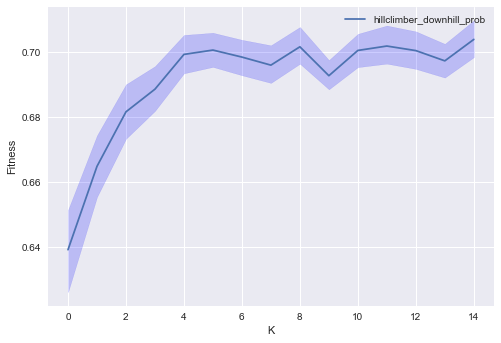

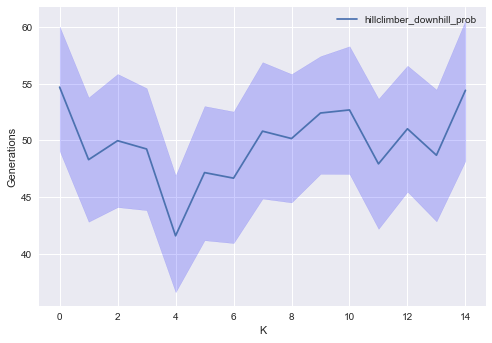

In [15]:
# plotting
plot_mean_and_bootstrapped_ci(input_data=fitness_found, name=name, y_label="Fitness")
plot_mean_and_bootstrapped_ci(input_data=generation_found, name=name, y_label="Generations")

### Q9: Visualizing Mulitple Runs
On the same plot (which may require modifying or reimplementing your plotting function, if you made one above), please plot the curves for all 4 of our experiments above on a single plot (including bootsrapped confidence intervals for all).  

*Hint*: Legends are especially important here!

*Hint*: It may be convenient to iterate over the dictionaries, turning them into lists before plotting (depending on your plotting script)

[array([0.64749614, 0.66980852]), array([0.68548857, 0.70724938]), array([0.69344789, 0.71310237]), array([0.69113922, 0.71153346]), array([0.69077107, 0.7082886 ]), array([0.65780031, 0.6962561 ]), array([0.6881845 , 0.70584084]), array([0.68439028, 0.70015541]), array([0.63438159, 0.68110258]), array([0.63356245, 0.68020461]), array([0.63221002, 0.66846493]), array([0.60996846, 0.66208028]), array([0.58397693, 0.64570785]), array([0.57031017, 0.634918  ]), array([0.55752656, 0.62686108])]
[array([0.6214698 , 0.64404732]), array([0.65789265, 0.67652096]), array([0.6754943 , 0.69026958]), array([0.68129691, 0.69441954]), array([0.68697754, 0.69963847]), array([0.69044266, 0.70072577]), array([0.69239698, 0.70255807]), array([0.69113453, 0.7021919 ]), array([0.69256898, 0.70380027]), array([0.6932847 , 0.70275309]), array([0.69383692, 0.70468017]), array([0.69328435, 0.70613195]), array([0.69655997, 0.70638139]), array([0.69506301, 0.7065391 ]), array([0.69581461, 0.70651202])]
[array([

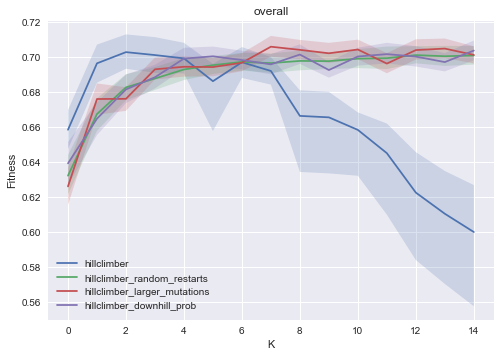

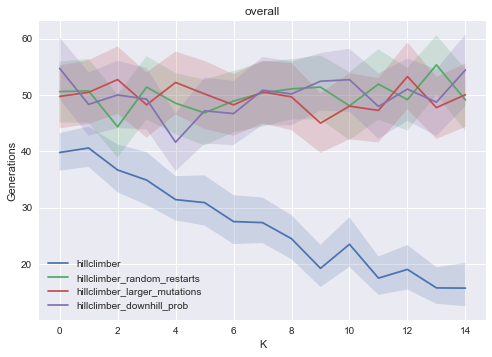

In [16]:
# plotting
def plot_mean_and_bootstrapped_ci_multiple(input_data = None, title = 'overall', name = "change me", x_label = "K", y_label="change me", y_limit = None):
    """
    
    parameters: 
    input_data: (numpy array of numpy arrays of shape (max_k, num_repitions)) solution metric to plot
    name: numpy array of string names for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """

    max_k = len(input_data[0])

#     plt.title(name)
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     plt.legend()
#     plt.show()

    fig, ax = plt.subplots()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    for i in range(len(input_data)):
        CIs = []
        mean_values = []
        for j in range(max_k):
            mean_values.append(np.mean(input_data[i][j]))
            CIs.append(bootstrap.ci(input_data[i][j], statfunction=np.mean))
        mean_values=np.array(mean_values)

        print(CIs)
        high = []
        low = []
        for j in range(len(CIs)):
            low.append(CIs[j][0])
            high.append(CIs[j][1])

        low = np.array(low)
        high = np.array(high)
#         fig, ax = plt.subplots()
        y = range(0, max_k)
        ax.plot(y, mean_values, label=name[i])
        ax.fill_between(y, high, low, alpha=.2)
        ax.legend()
        
experimental_results_fitnesses = []
experimental_results_generations = []
for k,v in experiment_results.items():
    for ki,vi in experiment_results[k].items():
        if ki == 'fitness_found':
            experimental_results_fitnesses.append(vi)
        if ki == 'generation_found':
            experimental_results_generations.append(vi)
plot_mean_and_bootstrapped_ci_multiple(input_data=experimental_results_fitnesses, name=[x for x in experiment_results.keys()], y_label="Fitness")
plot_mean_and_bootstrapped_ci_multiple(input_data=experimental_results_generations, name=[x for x in experiment_results.keys()], y_label="Generations")

### Q9b: Analyzing Mulitple Runs
Do any new relationships or questions occur to you as you view these?

**All of the edited versions of the hill climber that we played with look more similar to one another than to the original. They all have a similar effect on the outcome of the fitness values and the generational convergence. The original hill climber does extremely well on very simple fitness landscapes with a low generational convergence and high fitness. If the landscape is more rugged, these other versions tend to do better with higher fitnesses, but also with higher generational convergences. They continue looking for solutions where the unmodified hillclimber gives up.**

### Q10: Statistical Significance
Using the [`ranksums` test for significance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html), please compare the values for each algorithm at `K=14` using your saved `experiment_results`, reporting the p-value for each combination of the 4 experiments.  Please do this for both the resulting fitness values, and the generation for which that solution was found.  The output may look something like this:

<img src="terminal_output_2.png" align="left"/>

In [17]:
# test for statistical significance across treatments
k = 14

experimental_results_fitnesses_k = []
experimental_results_generations_k = []
for i in range(len(experiment_results.keys())):
    experimental_results_fitnesses_k.append(experimental_results_fitnesses[i][k])
    experimental_results_generations_k.append(experimental_results_generations[i][k])

print('fitness_found')
print('----------------')

for i in range(len(experimental_results_fitnesses_k)):
    for j in range(len(experimental_results_fitnesses_k)):
        if i >= j:
            continue
        else:
            print('{}: ({}) \t <-> \t {}: ({}) \t p-val={}'.format(
                    list(experiment_results.keys())[i], 
                    np.round(np.mean(experimental_results_fitnesses_k[i]),3), 
                    list(experiment_results.keys())[j], 
                    np.round(np.mean(experimental_results_fitnesses_k[j]),3),
                    np.round(scipy.stats.ranksums(experimental_results_fitnesses_k[i], experimental_results_fitnesses_k[j]).pvalue, 3)))
            
print()
print('generation_found')
print('----------------')
for i in range(len(experimental_results_generations_k)):
    for j in range(len(experimental_results_generations_k)):
        if i >= j:
            continue
        else:
            print('{}: ({}) \t <-> \t {}: ({}) \t p-val={}'.format(
                    list(experiment_results.keys())[i], 
                    np.round(np.mean(experimental_results_generations_k[i]),3), 
                    list(experiment_results.keys())[j], 
                    np.round(np.mean(experimental_results_generations_k[j]),3),
                    np.round(scipy.stats.ranksums(experimental_results_generations_k[i], experimental_results_generations_k[j]).pvalue, 3)))
            


...

fitness_found
----------------
hillclimber: (0.6) 	 <-> 	 hillclimber_random_restarts: (0.701) 	 p-val=0.0
hillclimber: (0.6) 	 <-> 	 hillclimber_larger_mutations: (0.701) 	 p-val=0.0
hillclimber: (0.6) 	 <-> 	 hillclimber_downhill_prob: (0.704) 	 p-val=0.0
hillclimber_random_restarts: (0.701) 	 <-> 	 hillclimber_larger_mutations: (0.701) 	 p-val=0.895
hillclimber_random_restarts: (0.701) 	 <-> 	 hillclimber_downhill_prob: (0.704) 	 p-val=0.45
hillclimber_larger_mutations: (0.701) 	 <-> 	 hillclimber_downhill_prob: (0.704) 	 p-val=0.517

generation_found
----------------
hillclimber: (15.7) 	 <-> 	 hillclimber_random_restarts: (49.09) 	 p-val=0.0
hillclimber: (15.7) 	 <-> 	 hillclimber_larger_mutations: (50.03) 	 p-val=0.0
hillclimber: (15.7) 	 <-> 	 hillclimber_downhill_prob: (54.42) 	 p-val=0.0
hillclimber_random_restarts: (49.09) 	 <-> 	 hillclimber_larger_mutations: (50.03) 	 p-val=0.765
hillclimber_random_restarts: (49.09) 	 <-> 	 hillclimber_downhill_prob: (54.42) 	 p-val=0.241
h

Ellipsis

### Q11: Hyperparameter Search
Its cool to see the differences that these approaches have over the baseline hillcimber, but the values for each parameter that we've asked you to investigate are totally arbitrarily chosen.  For example, who's to say that doing random resets every `20` generations is ideal?  So let's find out!  

Please modify the code above for which you varied `K` to see the effect on `Fitness` and `Time to Convergence (Generations)`, to now keep a constant `K=14` and vary how frequently do you random resets within the fixed `100` generations of evolution.  Explore this relationship for values of resets ranging from never (`0`) up to every `29` generations.  

In [18]:
name = 'hillclimber_restart_interval_k14'
# hyperparameters
n=15; max_k=14; repetitions = 100; max_restart_interval=29; num_elements_to_mutate=1; downhill_prob=0 

# initialize array to record results over different settings of k and repeated trials
solutions_found = np.zeros((max_restart_interval,repetitions,n))
fitness_found = np.zeros((max_restart_interval,repetitions))
generation_found = np.zeros((max_restart_interval,repetitions))

# initilize output
print(' i  mean fitness  mean generation found')
print('--  ------------  ---------------------')

# for many values of k
for i in range (max_restart_interval):
    # for many repeated (independent -- make sure your results differ each run!) trials
    for j in range (repetitions):
        l = Landscape(n, max_k) # generate a random fitness landscape with this level of ruggeddness
 
        # run a hillclimber and record outputs
        solutions_found[i][j], fitness_found[i][j], generation_found[i][j] = hillclimber(bit_string_length=n, restart_every=i, fitness_function=l.get_fitness, num_elements_to_mutate=num_elements_to_mutate, downhill_prob=downhill_prob)

        
        
    # print average results for all repitions of this k
#     print(k)
#     print(np.mean(fitness_found[k]))
#     print(np.mean)
    print('{}\t{}\t\t{}'.format(i, np.round(np.mean(fitness_found[i]), 3), np.round(np.mean(generation_found[i]), 3)))

experiment_results2 = {}
experiment_results2[name] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found}

 i  mean fitness  mean generation found
--  ------------  ---------------------
0	0.647		14.59
1	0.704		50.54
2	0.702		59.92
3	0.639		15.19
4	0.701		49.2
5	0.701		50.9
6	0.64		12.22
7	0.641		14.79
8	0.642		17.8
9	0.64		16.44
10	0.7		51.17
11	0.643		14.19
12	0.646		14.42
13	0.642		14.42
14	0.633		12.65
15	0.642		13.33
16	0.643		15.57
17	0.645		15.93
18	0.638		15.17
19	0.639		16.11
20	0.7		56.16
21	0.649		14.34
22	0.646		16.14
23	0.646		12.84
24	0.638		15.88
25	0.697		45.28
26	0.639		14.41
27	0.647		17.73
28	0.644		14.37


### Q11b: Visualization
Similar to before (with `K`), please plot `Fitness` and `Time to Convergence (Generations)` as a funciton of how frequently we apply random restarts (`Restart Every`)

[array([0.63979479, 0.6558371 ]), array([0.69843942, 0.70947372]), array([0.69595968, 0.70823474]), array([0.63157139, 0.64608332]), array([0.69660902, 0.70700913]), array([0.69531145, 0.70691646]), array([0.63179894, 0.64733601]), array([0.63308079, 0.6479798 ]), array([0.63493384, 0.64916017]), array([0.63266098, 0.64808684]), array([0.69510403, 0.70459045]), array([0.63511436, 0.65083932]), array([0.63872278, 0.65329287]), array([0.63419281, 0.64965998]), array([0.62534978, 0.64087261]), array([0.63353357, 0.65003406]), array([0.63565789, 0.64931292]), array([0.63768991, 0.65182113]), array([0.63037617, 0.64504405]), array([0.63182594, 0.64617832]), array([0.6955379 , 0.70540429]), array([0.64163529, 0.65633073]), array([0.63828364, 0.65342869]), array([0.63859287, 0.65379062]), array([0.62968912, 0.64675029]), array([0.69232875, 0.70303473]), array([0.63123205, 0.64719684]), array([0.63797326, 0.65525104]), array([0.63766244, 0.65174747])]
[array([11.64, 18.17]), array([44.5 , 56.5

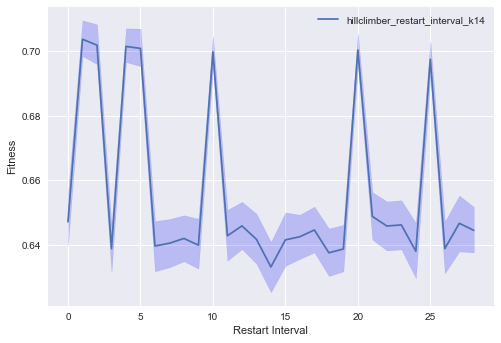

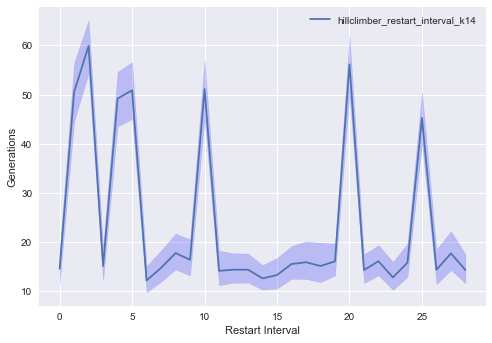

In [19]:
# plotting
plot_mean_and_bootstrapped_ci(input_data=fitness_found, name=name, y_label="Fitness", x_label="Restart Interval")
plot_mean_and_bootstrapped_ci(input_data=generation_found, name=name, y_label="Generations", x_label="Restart Interval")

### Q11c: The effect of ruggedness
The above plots are for a single value of `K`=14.  Repeat this same experiment below, just changing the value of `K` to `0`, to see what this experiment looksl like on a less-rugged landscape.

In [20]:
name = 'hillclimber_restart_interval_k0'
# hyperparameters
n=15; max_k=0; repetitions = 100; max_restart_interval=29; num_elements_to_mutate=1; downhill_prob=0 

# initialize array to record results over different settings of k and repeated trials
solutions_found = np.zeros((max_restart_interval,repetitions,n))
fitness_found = np.zeros((max_restart_interval,repetitions))
generation_found = np.zeros((max_restart_interval,repetitions))

# initilize output
print(' i  mean fitness  mean generation found')
print('--  ------------  ---------------------')

# for many values of k
for i in range (max_restart_interval):
    # for many repeated (independent -- make sure your results differ each run!) trials
    for j in range (repetitions):
        l = Landscape(n, max_k) # generate a random fitness landscape with this level of ruggeddness
 
        # run a hillclimber and record outputs
        solutions_found[i][j], fitness_found[i][j], generation_found[i][j] = hillclimber(bit_string_length=n, restart_every=i, fitness_function=l.get_fitness, num_elements_to_mutate=num_elements_to_mutate, downhill_prob=downhill_prob)

        
        
    # print average results for all repitions of this k
#     print(k)
#     print(np.mean(fitness_found[k]))
#     print(np.mean)
    print('{}\t{}\t\t{}'.format(i, np.round(np.mean(fitness_found[i]), 3), np.round(np.mean(generation_found[i]), 3)))

experiment_results2 = {}
experiment_results2[name] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found}

 i  mean fitness  mean generation found
--  ------------  ---------------------
0	0.656		34.04
1	0.63		50.64
2	0.636		47.19
3	0.662		35.15
4	0.643		48.94
5	0.627		53.13
6	0.653		31.73
7	0.656		38.91
8	0.65		37.73
9	0.655		34.83
10	0.633		44.55
11	0.654		37.17
12	0.663		37.36
13	0.654		31.63
14	0.654		33.1
15	0.652		32.89
16	0.67		35.77
17	0.661		36.18
18	0.66		34.91
19	0.649		35.52
20	0.627		48.88
21	0.661		33.1
22	0.662		34.71
23	0.646		33.53
24	0.644		35.87
25	0.624		53.76
26	0.657		34.93
27	0.658		34.77
28	0.654		33.99


[array([0.643642  , 0.66755491]), array([0.6196107 , 0.64129808]), array([0.62494654, 0.64720644]), array([0.65195199, 0.67155997]), array([0.63188279, 0.65477705]), array([0.61671817, 0.63651475]), array([0.64165012, 0.66448782]), array([0.64329542, 0.66803215]), array([0.63535543, 0.66239608]), array([0.64344285, 0.66580606]), array([0.62154342, 0.64466389]), array([0.64211887, 0.66450489]), array([0.64850856, 0.67593909]), array([0.64098849, 0.66713914]), array([0.64302219, 0.66540637]), array([0.63765888, 0.66536976]), array([0.65687672, 0.6819247 ]), array([0.64971   , 0.67291191]), array([0.64814036, 0.66987981]), array([0.63630912, 0.66088625]), array([0.61622078, 0.63735828]), array([0.64788456, 0.67272813]), array([0.64954208, 0.67364355]), array([0.63230653, 0.65888825]), array([0.63249319, 0.65545135]), array([0.6128782 , 0.63674768]), array([0.64303697, 0.67062448]), array([0.64457683, 0.67174531]), array([0.64272239, 0.66597975])]
[array([30.91, 37.52]), array([44.96, 56.3

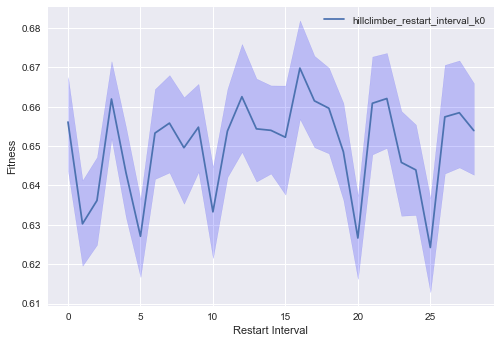

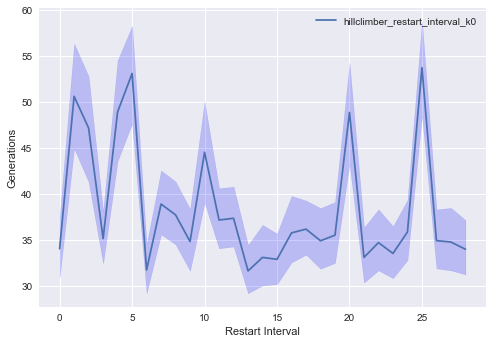

In [21]:
# plotting
plot_mean_and_bootstrapped_ci(input_data=fitness_found, name=name, y_label="Fitness", x_label="Restart Interval")
plot_mean_and_bootstrapped_ci(input_data=generation_found, name=name, y_label="Generations", x_label="Restart Interval")

### Q12: Analysis
What trends to you see from the figs for `K=14` vs. `K=0`?  Are you surprised by this?  What does it imply about the relationship between ruggedness and random restarts?  Does it make you want to try and other experiments (what would be the next thing you'd investigate)?

**These charts are hard to dissect. I question whether I generated them correctly or not. It seems that when the landscape is very rugged then there is a positive correlation between generational convergence and fitness values across the restart interval range. On the other hand, there is a negative correlation between these two metrics when the landscape is less rugged. This would mean that with more rugged landscapes if some optima is found late in the game, it has a good probability of being a good one. It's a rugged landscape so we need more exploration with the restarts. If on the other hand the landscape is less rugged, then we aren't giving the hillclimber enough time to climb a hill and when it restarts it is unlikely to land on top of one. This could be wrong, but I'm typing this as a stream of consciousness at the moment. These are just some thoughts and speculations.**

### Congratulations, you made it to the end!
Wow that was a bit of a long one.  Hopefully you enjoyed the open-ended experimentation though

Please save this file as a .ipynb, and also download it as a .pdf, uploading **both** to blackboard to complete this assignment.  

For your submission, please make sure that you have renamed this file (and that the resulting pdf follows suit) to replce `[netid]` with your UVM netid.  This will greatly simplify our grading pipeline, and make sure that you receive credit for your work.  

#### Academic Integrity Attribution
During this assignment I collaborated with:

**Just me again.**